CSC with a Spatial Mask
=======================

This example demonstrates the use of [cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) for convolutional sparse coding with a spatial mask [[50]](http://sporco.rtfd.org/en/latest/zreferences.html#id53). If the ``sporco-cuda`` extension is installed and a GPU is available, a GPU accelerated version is used. The example problem is inpainting of randomly distributed corruption of a greyscale image.

In [1]:
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco import util
from sporco import signal
from sporco import metric
from sporco import plot
plot.config_notebook_plotting()
from sporco.admm import tvl2
from sporco.admm import cbpdn
from sporco.fft import fftconv
from sporco import cuda

# If running in a notebook, try to use wurlitzer so that output from the CUDA
# code will be properly captured in the notebook.
sys_pipes = util.notebook_system_output()

Load a reference image.

In [2]:
img = util.ExampleImages().image('monarch.png', zoom=0.5, scaled=True,
                                 gray=True, idxexp=np.s_[:, 160:672])

Create random mask and apply to reference image to obtain test image. (The call to ``numpy.random.seed`` ensures that the pseudo-random noise is reproducible.)

In [3]:
np.random.seed(12345)
frc = 0.5
msk = signal.rndmask(img.shape, frc, dtype=np.float32)
imgw = msk * img

Define pad and crop functions.

In [4]:
pn = 8
spad = lambda x:  np.pad(x, pn, mode='symmetric')
zpad = lambda x:  np.pad(x, pn, mode='constant')
crop = lambda x: x[pn:-pn, pn:-pn]

Construct padded mask and test image.

In [5]:
mskp = zpad(msk)
imgwp = spad(imgw)

$\ell_2$-TV denoising with a spatial mask as a non-linear lowpass filter. The highpass component is the difference between the test image and the lowpass component, multiplied by the mask for faster convergence of the convolutional sparse coding (see [[60]](http://sporco.rtfd.org/en/latest/zreferences.html#id60)).

In [6]:
lmbda = 0.05
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
                    'DFidWeight': mskp, 'gEvalY': False,
                    'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(imgwp, lmbda, opt)
sl = b.solve()
sh = mskp * (imgwp - sl)

Load dictionary.

In [7]:
D = util.convdicts()['G:8x8x128']

Set up [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) options.

In [8]:
lmbda = 2e-2
opt = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': 200,
                    'HighMemSolve': True, 'RelStopTol': 5e-3,
                    'AuxVarObj': False, 'RelaxParam': 1.8,
                    'rho': 5e1*lmbda + 1e-1, 'AutoRho': {'Enabled': False,
                    'StdResiduals': False}})

Construct [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) wrapper for [admm.cbpdn.ConvBPDN](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDN) and solve via wrapper. This example could also have made use of [admm.cbpdn.ConvBPDNMaskDcpl](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNMaskDcpl) (see example `cbpdn_md_gry`), which has similar performance in this application, but [admm.cbpdn.AddMaskSim](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.AddMaskSim) has the advantage of greater flexibility in that the wrapper can be applied to a variety of CSC solver objects. If the ``sporco-cuda`` extension is installed and a GPU is available, use the CUDA implementation of this combination.

In [9]:
if cuda.device_count() > 0:
    ams = None
    print('%s GPU found: running CUDA solver' % cuda.device_name())
    tm = util.Timer()
    with sys_pipes(), util.ContextTimer(tm):
        X = cuda.cbpdnmsk(D, sh, mskp, lmbda, opt)
    t = tm.elapsed()
    imgr = crop(sl + np.sum(fftconv(D, X, axes=(0, 1)), axis=-1))
else:
    ams = cbpdn.AddMaskSim(cbpdn.ConvBPDN, D, sh, mskp, lmbda, opt=opt)
    X = ams.solve()
    t = ams.timer.elapsed('solve')
    imgr = crop(sl + ams.reconstruct().squeeze())

GeForce RTX 2080 Ti GPU found: running CUDA solver


Itn   Fnc       DFid      Regℓ1     r         s         ρ
----------------------------------------------------------------
   0  3.07e+01  4.16e-02  1.53e+03  9.94e-01  1.85e-01  1.10e+00
   1  2.69e+01  2.13e-01  1.33e+03  8.05e-01  2.20e-01  1.10e+00
   2  2.51e+01  3.39e-01  1.24e+03  4.52e-01  1.83e-01  1.10e+00
   3  2.41e+01  4.19e-01  1.19e+03  3.05e-01  1.48e-01  1.10e+00
   4  2.34e+01  4.80e-01  1.14e+03  2.30e-01  1.24e-01  1.10e+00
   5  2.29e+01  5.29e-01  1.12e+03  1.87e-01  1.07e-01  1.10e+00
   6  2.27e+01  5.69e-01  1.11e+03  1.60e-01  9.26e-02  1.10e+00
   7  2.26e+01  6.02e-01  1.10e+03  1.41e-01  8.09e-02  1.10e+00
   8  2.25e+01  6.33e-01  1.09e+03  1.27e-01  7.18e-02  1.10e+00
   9  2.24e+01  6.61e-01  1.09e+03  1.17e-01  6.47e-02  1.10e+00
  10  2.22e+01  6.88e-01  1.07e+03  1.09e-01  5.94e-02  1.10e+00
  11  2.19e+01  7.15e-01  1.06e+03  1.02e-01  5.54e-02  1.10e+00
  12  2.16e+01  7.42e-01  1.04e+03  9.68e-02  5.24e-02  1.10e+00
  13  2.13e+01  7.68e-01  1.03e+

Display solve time and reconstruction performance.

In [10]:
print("AddMaskSim wrapped ConvBPDN solve time: %.2fs" % t)
print("Corrupted image PSNR: %5.2f dB" % metric.psnr(img, imgw))
print("Recovered image PSNR: %5.2f dB" % metric.psnr(img, imgr))

AddMaskSim wrapped ConvBPDN solve time: 1.49s
Corrupted image PSNR:  9.10 dB
Recovered image PSNR: 24.56 dB


Display reference, test, and reconstructed image

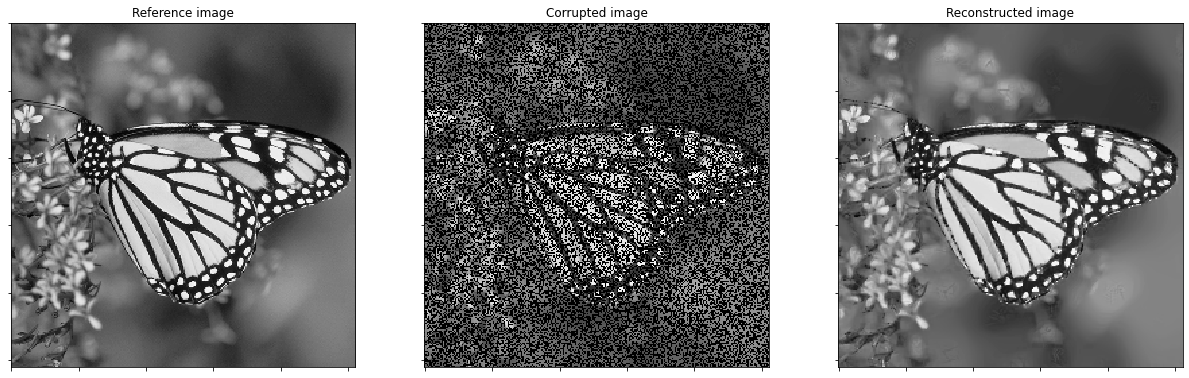

In [11]:
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.imview(img, title='Reference image', fig=fig)
plot.subplot(1, 3, 2)
plot.imview(imgw, title='Corrupted image', fig=fig)
plot.subplot(1, 3, 3)
plot.imview(imgr, title='Reconstructed image', fig=fig)
fig.show()

Display lowpass component and sparse representation

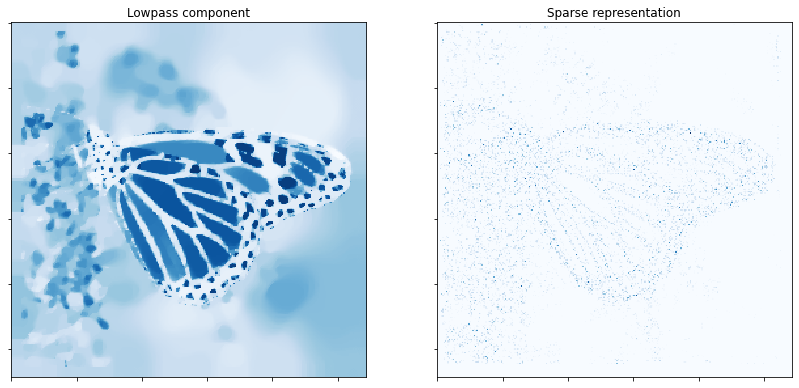

In [12]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(sl, cmap=plot.cm.Blues, title='Lowpass component', fig=fig)
plot.subplot(1, 2, 2)
plot.imview(np.sum(abs(X).squeeze(), axis=-1), cmap=plot.cm.Blues,
            title='Sparse representation', fig=fig)
fig.show()

Plot functional value, residuals, and rho (not available if GPU implementation used).

In [13]:
if ams is not None:
    its = ams.getitstat()
    fig = plot.figure(figsize=(21, 7))
    plot.subplot(1, 3, 1)
    plot.plot(its.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
    plot.subplot(1, 3, 2)
    plot.plot(np.vstack((its.PrimalRsdl, its.DualRsdl)).T, ptyp='semilogy',
              xlbl='Iterations', ylbl='Residual', lgnd=['Primal', 'Dual'],
              fig=fig)
    plot.subplot(1, 3, 3)
    plot.plot(its.Rho, xlbl='Iterations', ylbl='Penalty Parameter', fig=fig)
    fig.show()